In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import math
import numpy as np
import random
from math import sqrt
from pandas import read_csv, DataFrame
from urllib.request import urlopen
from zipfile import ZipFile
from tqdm import trange
from torch.nn.utils import weight_norm
import matplotlib.pyplot as plt
import torch.nn as nn
import scipy.optimize
import torch
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
from torchvision import transforms
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torch.nn.functional as F
np.random.seed(100)

In [2]:
#BIM攻击
def bim_attack(data,epsilon, pertubation,iter_eps, label, criterion, model):
    adv_x = data + pertubation
    adv_x.requires_grad = True
    pred = model(adv_x)
    loss = criterion(pred,label)
    model.zero_grad()
    loss.backward()
    data_grad = adv_x.grad.data
    sign_data_grad = data_grad.sign()
    pertubation = iter_eps * sign_data_grad
    # Collect the element-wise sign of the data gradient
    adv_x=adv_x.detach()+ pertubation
    data=data.detach()
    
    pertubation=torch.clamp(adv_x-data,-epsilon,epsilon)
    #print(pertubation.type())
    # Create the perturbed image by adjusting each pixel of the input image
    return pertubation

In [3]:
name = 'LD2011_2014.txt'
save_name = 'elect'
window_size = 192
stride_size = 24
num_covariates = 4
train_start = '2011-01-01 00:00:00'
train_end = '2014-08-31 23:00:00'
test_start = '2014-08-25 00:00:00' #need additional 7 days as given info
test_end = '2014-09-07 23:00:00'
pred_days = 7
given_days = 7
csv_path='./LD2011_2014.txt'
save_path = './Eledata/'

data_frame = pd.read_csv(csv_path, sep=";", index_col=0, parse_dates=True, decimal=',')
data_frame = data_frame.resample('1H',label = 'left',closed = 'right').sum()[train_start:test_end]
data_frame.fillna(0, inplace=True)
print(data_frame)
user = "MT_208"
df=data_frame[[user]]
print(df)
close_min=df[user].min()
close_max=df[user].max()
df=df.apply(lambda x:(x-min(x))/(max(x)-min(x)))
total_len=df.shape[0]
sequence=168
hour = 24
X=[]
Y=[]
for i in range(df.shape[0]-sequence-hour):
    X.append(np.array(df.iloc[i:(i+sequence),].values,dtype=np.float32))
    Y.append(np.array(df.iloc[(i+sequence):(i+sequence+hour),0],dtype=np.float32))

                        MT_001      MT_002    MT_003      MT_004      MT_005  \
Data                                                                           
2011-01-01 00:00:00   0.000000    0.000000  0.000000    0.000000    0.000000   
2011-01-01 01:00:00   0.000000    0.000000  0.000000    0.000000    0.000000   
2011-01-01 02:00:00   0.000000    0.000000  0.000000    0.000000    0.000000   
2011-01-01 03:00:00   0.000000    0.000000  0.000000    0.000000    0.000000   
2011-01-01 04:00:00   0.000000    0.000000  0.000000    0.000000    0.000000   
...                        ...         ...       ...         ...         ...   
2014-09-07 19:00:00  36.802030  142.958748  7.819288  534.552846  123.170732   
2014-09-07 20:00:00  13.959391  135.846373  6.950478  607.723577  163.414634   
2014-09-07 21:00:00  46.954315  130.867710  6.950478  603.658537  195.121951   
2014-09-07 22:00:00  65.989848  128.733997  6.950478  542.682927  209.756098   
2014-09-07 23:00:00  65.989848  127.3115

In [4]:
#rewrite Dataset
class Mydataset(Dataset):
    def __init__(self,xx,yy,transform=None):
        self.x=xx
        self.y=yy
        self.tranform = transform

    def __getitem__(self,index):
        x1=self.x[index]
        y1=self.y[index]
        if self.tranform !=None:
            return self.tranform(x1),y1
        return x1,y1

    def __len__(self):
        return len(self.x)
# batch
train_num = 0.8
trainx,trainy=X[:int(train_num*total_len)],Y[:int(train_num*total_len)]
testx,testy=X[int(train_num*total_len):],Y[int(train_num*total_len):]
train_loader=DataLoader(dataset=Mydataset(trainx,trainy,transform=None), batch_size=2048, shuffle=False)
test_loader=DataLoader(dataset=Mydataset(testx,testy), batch_size=2048, shuffle=False)

class lstm(nn.Module):
    def __init__(self,input_size=1,hidden_size=128,output_size=24,num_layers = 1):
        super(lstm, self).__init__()
        #batch,seq_len, input_size
        self.hidden_size=hidden_size
        self.input_size=input_size
        self.output_size=output_size
        self.num_layers=num_layers
        self.rnn=nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,num_layers = self.num_layers, batch_first=True)
        self.linear=nn.Linear(self.hidden_size,self.output_size)
    def forward(self,x):
        out,(hidden,cell)=self.rnn(x)  # x.shape : batch,seq_len,hidden_size , hn.shape and cn.shape : num_layes * direction_numbers,batch,hidden_size
        a,b,c=hidden.shape

        out=self.linear(hidden.reshape(a*b,c))
        #print(out.shape)
        return out

#model=TCN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=lstm().to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)

preds=[]
labels=[]
for i in range(60):
    total_loss=0
    for idx,(data,label) in enumerate(train_loader):
        data1=data.to(device).squeeze(1)
        pred=model(Variable(data1))
        label=label.to(device)

        loss=criterion(pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    print("epoch%d: loss:%f"%(i+1,total_loss))
#test
preds=[]
labels=[]
total_loss = 0
ll=0
for idx, (x, label) in enumerate(test_loader):
    x = x.to(device).squeeze(1)  # batch_size,seq_len,input_size
    pred=model(x)
    label=label.to(device)
    loss=criterion(pred,label)

    total_loss+=loss.item()
    preds.extend(pred.data.squeeze(1).tolist())
    labels.extend(label.tolist())
true_power = []
pred_power = []
for i in range(len(labels)):
    true_power.append(labels[i][0])
    pred_power.append(preds[i][0])
print("loss: ",total_loss)

epoch1: loss:1.416232
epoch2: loss:0.435649
epoch3: loss:0.416110
epoch4: loss:0.341277
epoch5: loss:0.327485
epoch6: loss:0.339991
epoch7: loss:0.328282
epoch8: loss:0.323858
epoch9: loss:0.306964
epoch10: loss:0.274376
epoch11: loss:0.249206
epoch12: loss:0.226095
epoch13: loss:0.181487
epoch14: loss:0.171517
epoch15: loss:0.158622
epoch16: loss:0.129227
epoch17: loss:0.135626
epoch18: loss:0.145682
epoch19: loss:0.161543
epoch20: loss:0.119886
epoch21: loss:0.110985
epoch22: loss:0.114306
epoch23: loss:0.115272
epoch24: loss:0.100140
epoch25: loss:0.086986
epoch26: loss:0.084419
epoch27: loss:0.089322
epoch28: loss:0.089492
epoch29: loss:0.076458
epoch30: loss:0.065901
epoch31: loss:0.059166
epoch32: loss:0.069008
epoch33: loss:0.076228
epoch34: loss:0.070348
epoch35: loss:0.053841
epoch36: loss:0.049995
epoch37: loss:0.056662
epoch38: loss:0.059575
epoch39: loss:0.057345
epoch40: loss:0.056075
epoch41: loss:0.052318
epoch42: loss:0.050442
epoch43: loss:0.045623
epoch44: loss:0.0448

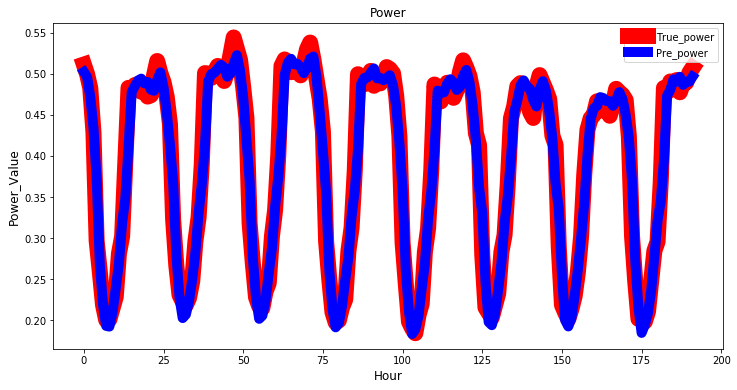

In [5]:
start_day = 24
dis_day = 32
plt.figure(figsize=(12,6))
plt.title('Power')
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Power_Value', fontsize = 12)
plt.plot(true_power[24*start_day:24*dis_day],"r",label="True",linewidth=16)
plt.plot(pred_power[24*start_day:24*dis_day],"b",label="Pred",linewidth=10)
plt.legend(['True_power', 'Pre_power'], loc='best')
plt.show()

In [6]:
def predict_classes(x, data,label, model, pertubation):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    seq_perturbed = []
    #print(pertubation)
    for i in range(len(x)):
        if x[i] >= 0.5:
            seq_perturbed.append(pertubation[0][i][0])
        else:
            seq_perturbed.append(data[0][i][0])
    
    seq_perturbed = torch.tensor(seq_perturbed)
    seq_perturbed = seq_perturbed.view([1,len(x),1])
    seq_perturbed = seq_perturbed.to(device).float()
    predictions = model(seq_perturbed)
    label = label.to(device)
    loss=criterion(predictions,label)
    # This function should always be minimized, so return its complement if needed
    return 100 - loss
def attack_success(x, data, label, target_loss_data, model, pertubation):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_seq = []
    for i in range(len(x)):
        if x[i] >= 0.5:
            attack_seq.append(pertubation[0][i][0])
        else:
            attack_seq.append(data[0][i][0])
    attack_seq = torch.tensor(attack_seq)
    attack_seq = attack_seq.view([1,len(x),1])
    target_loss_data = target_loss_data.to(device)
    attack_seq = attack_seq.to(device).float()
    label = label.to(device)
    pre_loss = model(target_loss_data)
    predictions = model(attack_seq)
    loss = criterion(predictions,label)
    loss_standard = criterion(pre_loss,label)
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True

    if loss >= (loss_standard*9):
        print("success attack!")
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

In [7]:
def all_attack(model, criterion, test_loader, device, epsilon):
    preds=[]
    adv_preds=[]
    test_x=[]
    test_all_adv=[]
    num_iter = 50
    iter_eps = 0.02
    #epsilon = 0.08
    total_loss = 0
    adv_total_loss = 0
    for idx, (x, label) in enumerate(test_loader):
        x = x.to(device).squeeze(1)  # batch_size,seq_len,input_size
        pred=model(x)
        label = label.to(device)
        loss=criterion(pred,label)
        pertubation = torch.zeros(x.shape)
        pertubation = pertubation.to(device)
        for i in range(num_iter):
            pertubation = bim_attack(x,epsilon, pertubation,iter_eps, label, criterion, model) # BIM
        perturbed_data = x + pertubation
        adv_pred=model(perturbed_data)
        adv_loss=criterion(adv_pred,label)
        for i in range(len(x)):
            test_x.append(x[i][0][0])
            test_all_adv.append(perturbed_data[i][0][0])  
        total_loss+=loss.item()
        adv_total_loss+=adv_loss.item()
        preds.extend(pred.data.squeeze(1).tolist())
        adv_preds.extend(adv_pred.data.squeeze(1).tolist())
    print("all_attack_RMSE: ")
    print("loss: ",total_loss)
    print("adv_loss: ",adv_total_loss)
    return adv_preds, adv_total_loss, test_all_adv
def part_attack(model, criterion, test_loader, device,epsilon):
    preds=[]
    adv_part_preds=[]
    labels=[]
    test_part_adv=[]
    ori_data=[]
    num_iter = 50
    iter_eps = 0.02
    #epsilon = 0.05
    total_loss = 0
    adv_part_total_loss = 0
    #part jiange
    gap =48
    #raodong qujian
    adv_len = 48
    for idx, (x, label) in enumerate(test_loader):
        x = x.to(device).squeeze(1)  # batch_size,seq_len,input_size
        pred=model(x)
        label = label.to(device)
        loss=criterion(pred,label)
        pertubation=torch.zeros(x.shape)
        pertubation = pertubation.to(device)
        for i in range(num_iter):
            pertubation = bim_attack(x,epsilon, pertubation,iter_eps, label, criterion, model) # BIM
        for i in range(len(x)):
            # 168
            for j in range(0,len(pertubation[i])):
                if i%(adv_len+gap)<gap and j == 0:
                    pertubation[i][j:j+gap-i%(adv_len+gap)] = 0
                if (j+i) % (adv_len+gap) == 0 and j != 0:
                    pertubation[i][j:j+gap] = 0
        perturbed_data = x + pertubation
        adv_part_pred=model(perturbed_data)
        adv_loss=criterion(adv_part_pred,label)
        for i in range(len(x)):
            ori_data.append(x[i][0][0])
            test_part_adv.append(perturbed_data[i][0][0])  
        total_loss+=loss.item()
        adv_part_total_loss+=adv_loss.item()
        preds.extend(pred.data.squeeze(1).tolist())
        adv_part_preds.extend(adv_part_pred.data.squeeze(1).tolist())
        labels.extend(label.tolist())
    print("part_attack_RMSE:")
    print("loss: ",total_loss)
    print("adv_part_loss: ",adv_part_total_loss)
    
    return adv_part_preds, adv_part_total_loss, test_part_adv, ori_data
def get_DE_data(dis_day, test_part_adv,ori_data, test_all_adv,data_loader):
  
    data_x=[]
    
    seq_b = dis_day
    seq_o = dis_day + 168
    # 设定范围
    seq_loss_data = test_part_adv[seq_b:seq_o]
    seq_data = ori_data[seq_b:seq_o]
    seq_adv_data = test_part_adv[seq_b:seq_o]
    all_adv_data = test_all_adv[seq_b:seq_o]
    seq_label = ori_data[seq_o + 1:seq_o + 25]
    
    
    #to tensor
    all_adv_data = torch.tensor(all_adv_data)
    seq_data = torch.tensor(seq_data)
    seq_adv_data = torch.tensor(seq_adv_data)
    seq_loss_data = torch.tensor(seq_loss_data)
    seq_label = torch.tensor(seq_label)
    
    #view
    seq_label = seq_label.view([1,24])
    seq_data = seq_data.view([1,168,1])
    seq_adv_data = seq_adv_data.view([1,168,1])
    seq_loss_data = seq_loss_data.view([1,168,1])
    all_adv_data = all_adv_data.view([1,168,1])
    #to device
    all_adv_data = all_adv_data.to(device).float()
    seq_data = seq_data.to(device).float()
    seq_adv_data = seq_adv_data.to(device).float()
    #predict
    ori_predictions = model(seq_data)
    all_attack_predictions = model(all_adv_data)
    part_attack_predictions = model(seq_adv_data)
    
    seq_label = seq_label.to(device)
    part_attack_loss = criterion(part_attack_predictions, seq_label)
    all_attack_loss = criterion(all_attack_predictions, seq_label)
    ori_loss=criterion(ori_predictions,seq_label)
    print("Original_loss:",ori_loss)
    print("All_attack_loss:", all_attack_loss)
    print("Part_attack_loss:", part_attack_loss)
    
    seq_adv_data = seq_adv_data.detach().cpu()
    all_adv_data = all_adv_data.detach().cpu()
    seq_data = seq_data.detach().cpu()
    return seq_data, seq_adv_data, seq_label, seq_loss_data
def attack(x_test,pertubation, seq_loss_data, model,label, maxiter=60, popsize=600):
    # Define bounds for a flat vector of x values
    # For more pixels, repeat this layout
    bounds = []
    for i in range(0,168):
        bounds.append((0,1))
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    # Zero all existing gradients
    # Calculate gradients of model in backward pass
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, seq_data, seq_label, model, pertubation)
    def callback_fn(x, convergence):
        return attack_success(x, x_test, label, seq_loss_data, model, pertubation)
    # Call Scipy's Implementation of Differential Evolution
    attack_result = scipy.optimize.differential_evolution(predict_fn, bounds, strategy = 'best2bin', maxiter=maxiter, popsize=popmul, mutation=0.5,
        recombination=0.1, atol=-1, callback=callback_fn, polish=False)
    # Calculate some useful statistics to return from this function
    res_attack_seq = []
    DE_sample = []
    res = attack_result.x
    for i in range(len(res)):
        if res[i] >= 0.5:
            res_attack_seq.append(pertubation[0][i][0])
            DE_sample.append(pertubation[0][i][0])
        else:
            res_attack_seq.append(x_test[0][i][0])
            DE_sample.append(x_test[0][i][0])
    res_attack_seq = torch.tensor(res_attack_seq)
    res_attack_seq = res_attack_seq.view([1,len(res),1])
    res_attack_seq = res_attack_seq.to(device).float()
    predictions = model(res_attack_seq)
    label = label.to(device)
    loss=criterion(predictions,label)
    
    return loss, predictions,DE_sample

In [8]:
dis_day = 1
#adv_preds = []
#adv_part_preds = []
epsilon = 0.06
adv_preds, all_attack_loss,test_all_adv = all_attack(model, criterion, test_loader,device,epsilon)
adv_part_preds, part_attack_loss,test_part_adv,ori_data = part_attack(model, criterion, test_loader,device,epsilon)

part_sample = []
all_sample = []
ori_sample = []
part_DE_sample = []

part_sample = test_part_adv[dis_day:dis_day+168]
all_sample = test_all_adv[dis_day:dis_day+168]
ori_sample = ori_data[dis_day:dis_day+168]


seq_data, seq_adv_data, seq_label, seq_loss_data= get_DE_data(dis_day, test_part_adv,ori_data, test_all_adv,test_loader)

# DE+part
res_loss, adv_part_DE_preds, part_DE_sample = attack(seq_data,seq_adv_data,seq_loss_data, model,seq_label)
print("Part+DE_loss: ", res_loss)
adv_part_DE_preds = adv_part_DE_preds.detach().cpu().numpy()

all_attack_RMSE: 
loss:  0.008458230062387884
adv_loss:  0.04150092415511608
part_attack_RMSE:
loss:  0.008458230062387884
adv_part_loss:  0.024219080107286572
Original_loss: tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)
All_attack_loss: tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)
Part_attack_loss: tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)
Part+DE_loss:  tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward0>)


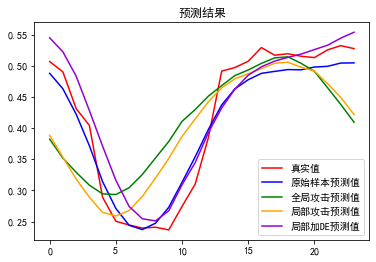

In [9]:
plt.rcParams['font.sans-serif']='SimHei' #设置中文显示
plt.title('预测结果')
plt.plot(labels[dis_day],"r",label="真实值")
plt.plot(preds[dis_day],"b",label="原始样本预测值")

plt.plot(adv_preds[dis_day],"green",label="全局攻击预测值")
plt.plot(adv_part_preds[dis_day],"orange",label="局部攻击预测值")

# plt.plot(all_attack_pre[0],"green",label="全局攻击预测值")
# plt.plot(part_attack_pre[0],"orange",label="局部攻击预测值")

plt.plot(adv_part_DE_preds[0],"darkviolet",label="局部加DE预测值")
plt.legend(loc='best')


plt.savefig('power_0.06_4.png',dpi=600)

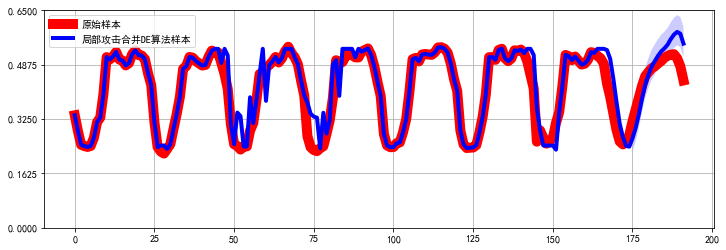

In [148]:
dis_all_DE = []
dis_all_ori = []
for i in range(len(ori_sample)):
    dis_all_ori.append(ori_sample[i])
for i in range(len(preds[dis_day])):
    dis_all_ori.append(preds[dis_day][i])
for i in range(len(part_DE_sample)):
        dis_all_DE.append(part_DE_sample[i])
for i in range(len(adv_part_DE_preds[0])):
    dis_all_DE.append(adv_part_DE_preds[0][i])
plt.rcParams['font.sans-serif']='SimHei' #设置中文显示
plt.figure(figsize=(12,4))
plt.plot(dis_all_ori,"r",label="原始样本",linewidth=10)
plt.ylim(0, 0.65)
new_ticks = np.linspace(0, 0.65, 5)
plt.yticks(new_ticks)
plt.plot(dis_all_DE,"b",label="局部攻击合并DE算法样本",linewidth=4)

x1 = []
y1 = []
z1 = []
x2 = []
y2 = []
z2 = []
for i in range(175,192):
    x1.append(i)
    y1.append(dis_all_DE[i]+0.05)
    z1.append(dis_all_DE[i]-0.04)

plt.fill_between(x1, y1, z1,facecolor = 'b',alpha=0.2)
#alpha=0.5

plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('over_all.png',dpi=600)
plt.show()

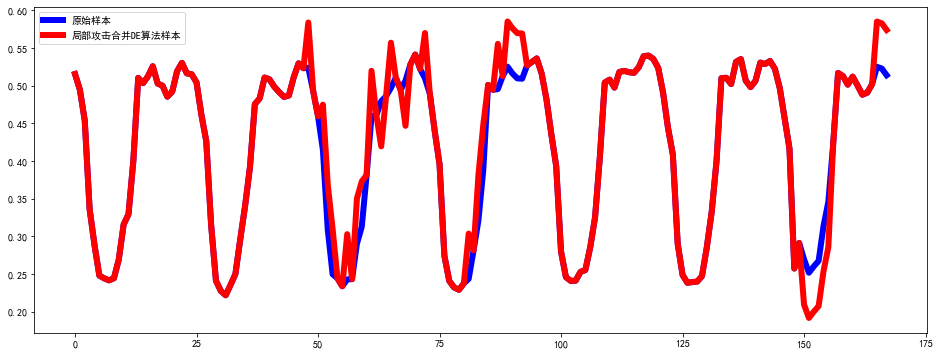

All_Sample RMSE: tensor(0.0036)
Part_Sample RMSE: tensor(0.0016)
Part_DE_Sample RMSE: tensor(0.0006)


In [11]:
dis_DE = []
dis_ALL = []
plt.rcParams['font.sans-serif']='SimHei' #设置中文显示
plt.figure(figsize=(16,6))
#plt.subplot(211)

#plt.title('ε = 0.06')
plt.plot(ori_sample,"b",label="原始样本",linewidth=6)
# for i in range(len(part_DE_sample[bi:ov])):
#     dis_DE.append(part_DE_sample[bi+i])

# part_sample =part_sample.detach().cpu().numpy()
# all_sample = all_sample.detach().cpu().numpy()
# ori_sample = ori_sample.detach().cpu().numpy()

#plt.plot(all_sample,"r",label="全局攻击样本",linewidth=6)
#plt.plot(part_sample,"r",label="局部攻击样本",linewidth=6)
plt.plot(part_DE_sample,"r",label="局部攻击合并DE算法样本",linewidth=6)
plt.legend(loc='upper left')
plt.show()
#plt.subplot(212)
#plt.figure(figsize=(16,6))
#plt.title('Sample result')
# for i in range(len(part_DE_sample[bi:ov])):
#     dis_ALL.append(all_sample[bi+i])
# #+random.uniform(0.01,0.05)
# plt.plot(ori_sample[bi:ov],"b",label="原始样本",linewidth=3)
# plt.plot(dis_ALL,"r",label="对抗样本",linewidth=3)
# #plt.plot(part_sample,"orange",label="Part_attack Sample",linewidth=3)
# #plt.plot(part_DE_sample[bi:ov],"darkviolet",label="Part_DE_attack Sample",linewidth=3)
# plt.legend(loc='best')
# plt.savefig('./Result_example.jpg')
# plt.show()
# ori_sample = torch.tensor(ori_sample, device='cpu')
# all_sample = torch.tensor(all_sample, device='cpu')
# part_sample = torch.tensor(part_sample, device='cpu')

# label_corr = pd.Series(np.array(ori_sample))
# all_corr = pd.Series(np.array(all_sample))
# part_corr = pd.Series(np.array(part_sample))
# DE_corr = pd.Series(np.array(part_DE_sample))

# all_corr_r=label_corr.corr(all_corr,method = 'pearson')
# part_corr_r=label_corr.corr(part_corr,method = 'pearson')
# DE_corr_r=label_corr.corr(DE_corr,method = 'pearson')

# print('全局攻击后样本与原始样本数据的相关系数：', all_corr_r)
# print('局部攻击后样本与原始样本数据的相关系数：', part_corr_r)
# print('局部和DE攻击后样本与原始样本数据的相关系数：', DE_corr_r)

all_sample = torch.tensor(all_sample)
ori_sample = torch.tensor(ori_sample)
part_sample = torch.tensor(part_sample)
part_DE_sample = torch.tensor(part_DE_sample)
print("All_Sample RMSE:", criterion(all_sample, ori_sample))
print("Part_Sample RMSE:", criterion(part_sample, ori_sample))
print("Part_DE_Sample RMSE:", criterion(part_DE_sample, ori_sample))